<font size="+3"><strong>6.3. Clustering with Multiple Features</strong></font>

In the previous lesson, we built a K-Means model to create clusters of respondents to the Survey of Consumer Finances. We made our clusters by looking at two features only, but there are hundreds of features in the dataset that we didn't take into account and that could contain valuable information. In this lesson, we'll examine all the features, selecting five to create clusters with. After we build our model and choose an appropriate number of clusters, we'll learn how to visualize multi-dimensional clusters in a 2D scatter plot using something called principal component analysis (PCA). 

In [27]:

import pandas as pd
import plotly.express as px
import wqet_grader
from IPython.display import VimeoVideo
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

wqet_grader.init("Project 6 Assessment")


In [28]:
from IPython.display import VimeoVideo

In [3]:
VimeoVideo("714612789", h="f4f8c10683", width=600)

# Prepare Data

## Import

We spent some time in the last lesson zooming in on a useful subset of the SCF, and this time, we're going to zoom in even further. One of the persistent issues we've had with this dataset is that it includes some outliers in the form of ultra-wealthy households. This didn't make much of a difference for our last analysis, but it could pose a problem in this lesson, so we're going to focus on families with net worth under \\$2 million.

In [4]:
VimeoVideo("714612746", h="07dc57f72c", width=600)

**Task 6.3.1:** Rewrite your `wrangle` function from the last lesson so that it returns a DataFrame of households whose net worth is less than \\$2 million and that have been turned down for credit or feared being denied credit in the past 5 years (see `"TURNFEAR"`). 

- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)
- [Subset a DataFrame by selecting one or more columns in pandas.](../%40textbook/04-pandas-advanced.ipynb#Subsetting-with-Masks)

In [29]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    mask=(df["TURNFEAR"] == 1) & (df["NETWORTH"]<2e6)
    df = df[mask]
    return df

In [30]:
df = wrangle("data/SCFP2019.csv.gz")
print(df.shape)
df.head()

(4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


## Explore

In this lesson, we want to make clusters using more than two features, but which of the 351 features should we choose? Often times, this decision will be made for you. For example, a stakeholder could give you a list of the features that are most important to them. If you don't have that limitation, though, another way to choose the best features for clustering is to determine which numerical features have the largest **variance**. That's what we'll do here. 

In [5]:
VimeoVideo("714612679", h="040facf6e2", width=600)

**Task 6.3.2:** Calculate the variance for all the features in `df`, and create a Series `top_ten_var` with the 10 features with the largest variance.

- [What's variance?](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Calculate the variance of a DataFrame or Series in pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)

In [31]:
x = df["DEBT"]
x.head()

5    12200.0
6    12600.0
7    15300.0
8    14100.0
9    15400.0
Name: DEBT, dtype: float64

In [32]:
x.var()

18482520920.408085

In [33]:
# Calculate variance, get 10 largest features
top_ten_var = df.var().sort_values().tail(10)
top_ten_var

PLOAN1      1.140894e+10
ACTBUS      1.251892e+10
BUS         1.256643e+10
KGTOTAL     1.346475e+10
DEBT        1.848252e+10
NHNFIN      2.254163e+10
HOUSES      2.388459e+10
NETWORTH    4.847029e+10
NFIN        5.713939e+10
ASSET       8.303967e+10
dtype: float64

As usual, it's harder to make sense of a list like this than it would be if we visualized it, so let's make a graph. 

In [10]:
VimeoVideo("714612647", h="5ecf36a0db", width=600)

**Task 6.3.3:** Use plotly express to create a horizontal bar chart of `top_ten_var`. Be sure to label your x-axis `"Variance"`, the y-axis `"Feature"`, and use the title `"SCF: High Variance Features"`.

- [What's a bar chart?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [Create a bar chart using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Bar-Chart)

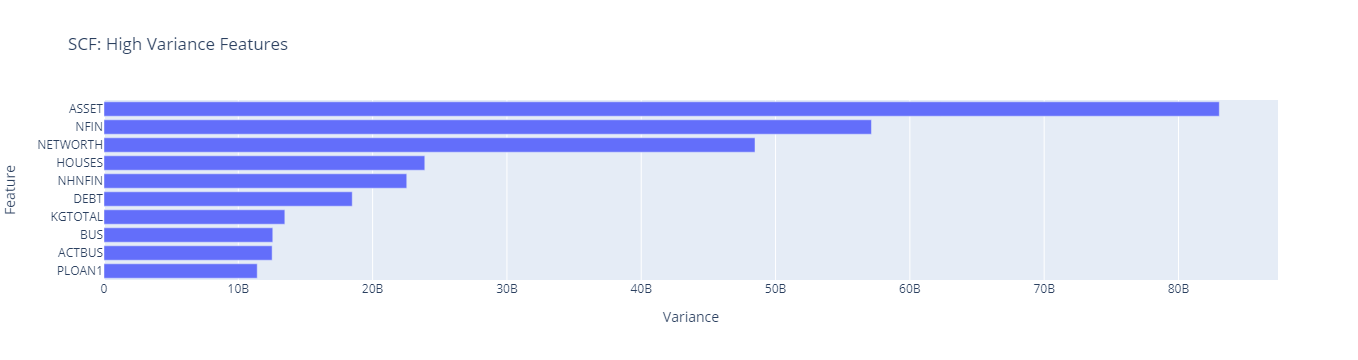

In [34]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance",yaxis_title="Feature")
fig.show()

One thing that we've seen throughout this project is that many of the wealth indicators are highly skewed, with a few outlier households having enormous wealth. Those outliers can affect our measure of variance. Let's see if that's the case with one of the features from `top_five_var`.

In [16]:
VimeoVideo("714612615", h="9ae23890fc", width=600)

**Task 6.3.4:** Use plotly express to create a horizontal boxplot of `"NHNFIN"` to determine if the values are skewed. Be sure to label the x-axis `"Value [$]"`, and use the title `"Distribution of Non-home, Non-Financial Assets"`.

- [What's a boxplot?](../%40textbook/06-visualization-matplotlib.ipynb#Boxplots)
- [Create a boxplot using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Boxplots)

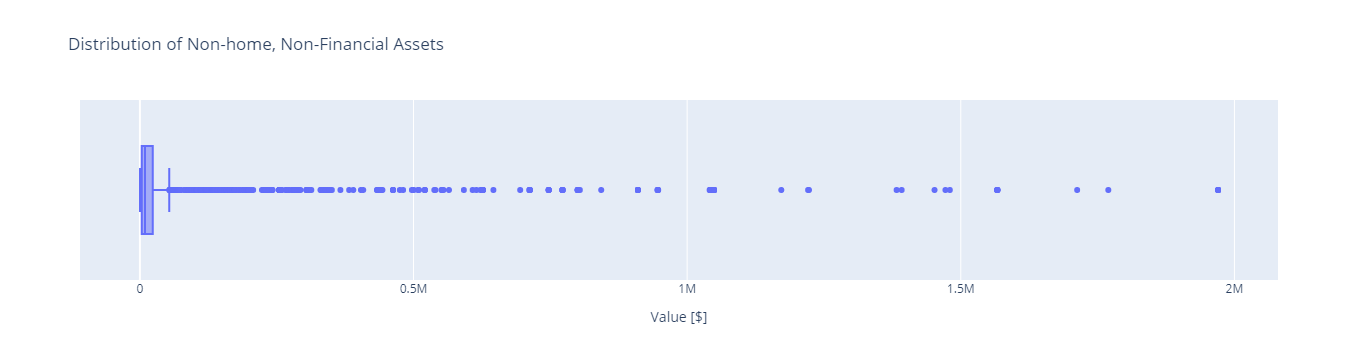

In [35]:
# Create a boxplot of `NHNFIN`
fig = px.box(
data_frame=df,
    x="NHNFIN",
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

Whoa! The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our `wrangle` function, the variance is still being distorted by some extreme outliers.

The best way to deal with this is to look at the **trimmed variance**, where we remove extreme values before calculating variance. We can do this using the `trimmed_variance` function from the `SciPy` library.

In [22]:
VimeoVideo("714612570", h="b1be8fb750", width=600)

**Task 6.3.5:** Calculate the trimmed variance for the features in `df`. Your calculations should not include the top and bottom 10% of observations. Then create a Series `top_ten_trim_var` with the 10 features with the largest variance.

- [What's trimmed variance?](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Calculate the trimmed variance of data using SciPy.](../%40textbook/05-pandas-summary-statistics.ipynb#Variance)
- [Apply a function to a DataFrame in pandas.](../%40textbook/04-pandas-advanced.ipynb#Applying-Functions-to-DataFrames-and-Series)

In [36]:
df["DEBT"].var()

18482520920.408085

In [37]:
trimmed_var(df["DEBT"])

3089864647.655702

In [38]:
df.apply(trimmed_var,limits=(0.1,0.1))

YY1             1.850508e+06
Y1              1.850507e+08
WGT             1.412290e+06
HHSEX           2.019627e-01
AGE             1.139698e+02
                    ...     
NWPCTLECAT      2.580682e+00
INCPCTLECAT     3.429553e+00
NINCPCTLECAT    3.523264e+00
INCQRTCAT       5.850373e-01
NINCQRTCAT      6.002715e-01
Length: 351, dtype: float64

In [39]:
# Calculate trimmed variance
top_ten_trim_var =  df.apply(trimmed_var,limits=(0.1,0.1)).sort_values().tail(10)
top_ten_trim_var


WAGEINC     5.550737e+08
HOMEEQ      7.338377e+08
NH_MORT     1.333125e+09
MRTHEL      1.380468e+09
PLOAN1      1.441968e+09
DEBT        3.089865e+09
NETWORTH    3.099929e+09
HOUSES      4.978660e+09
NFIN        8.456442e+09
ASSET       1.175370e+10
dtype: float64

Okay! Now that we've got a better set of numbers, let's make another bar graph.

In [12]:
VimeoVideo("714611188", h="d762a98b1e", width=600)

**Task 6.3.6:** Use plotly express to create a horizontal bar chart of `top_ten_trim_var`. Be sure to label your x-axis `"Trimmed Variance"`, the y-axis `"Feature"`, and use the title `"SCF: High Variance Features"`.

- [What's a bar chart?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [Create a bar chart using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Bar-Chart)

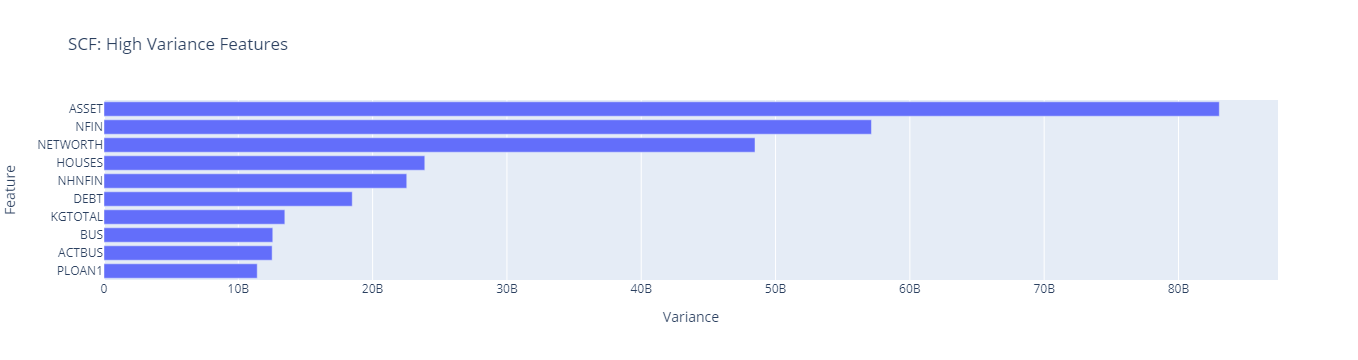

In [40]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance",yaxis_title="Feature")
fig.show()

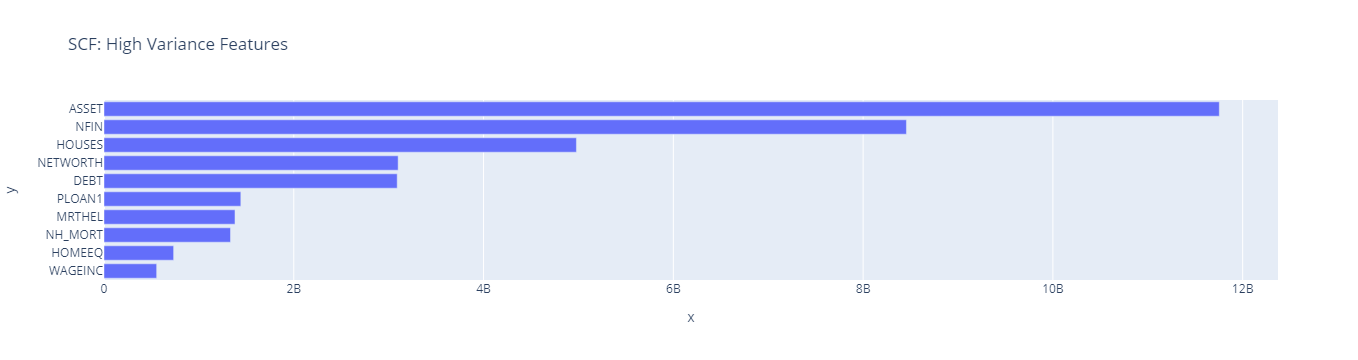

In [41]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="SCF: High Variance Features"
)

fig.show()

There are three things to notice in this plot. First, the variances have decreased a lot. In our previous chart, the x-axis went up to \\$80 billion; this one goes up to \\$12 billion. Second, the top 10 features have changed a bit. All the features relating to business ownership (`"...BUS"`) are gone. Finally, we can see that there are big differences in variance from feature to feature. For example, the variance for `"WAGEINC"` is around than \\$500 million, while the variance for `"ASSET"` is nearly \\$12 billion. In other words, these features have completely different scales. This is something that we'll need to address before we can make good clusters. 

In [42]:
VimeoVideo("714611161", h="61dee490ee", width=600)

**Task 6.3.7:** Generate a list `high_var_cols` with the column names of the  five features with the highest trimmed variance.

- [What's an index?](../%40textbook/01-python-getting-started.ipynb#Working-with-Lists)
- [Access the index of a DataFrame or Series in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrame-Indices)

In [20]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

## Split

Now that we've gotten our data to a place where we can use it, we can follow the steps we've used before to build a model, starting with a feature matrix.

In [43]:
VimeoVideo("714611148", h="f7fbd4bcc5", width=600)

**Task 6.3.8:** Create the feature matrix `X`. It should contain the five columns in `high_var_cols`.

- [What's a feature matrix?](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)
- [Subset a DataFrame by selecting one or more columns in pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 

In [22]:
X = df[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
5,12200.0,-6710.0,0.0,3900.0,5490.0
6,12600.0,-4710.0,0.0,6300.0,7890.0
7,15300.0,-8115.0,0.0,5600.0,7185.0
8,14100.0,-2510.0,0.0,10000.0,11590.0
9,15400.0,-5715.0,0.0,8100.0,9685.0


# Build Model

## Iterate

During our EDA, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is **standardization**, a statistical method for putting all the variables in a dataset on the same scale. Let's explore how that works here. Later, we'll incorporate it into our model pipeline. 

In [44]:
VimeoVideo("714611113", h="3671a603b5", width=600)

**Task 6.3.9:** Create a DataFrame `X_summary` with the mean and standard deviation for all the features in `X`.

- [Aggregate data in a DataFrame using one or more functions in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)

In [45]:
X_summary = X.aggregate(["mean","std"]).astype(int)
X_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,72701,76387,74530,117330,149089
std,135950,220159,154546,239038,288166


That's the information we need to standardize our data, so let's make it happen.

In [46]:
VimeoVideo("714611056", h="670f6bdb78", width=600)

**Task 6.3.10:** Create a `StandardScaler` transformer, use it to transform the data in `X`, and then put the transformed data into a DataFrame named `X_scaled`.

- [What's standardization?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Standardization)
- [Transform data using a transformer in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [52]:
x=X["DEBT"]
print(x.mean())
print(x.std())

72701.25848800362
135950.4355285708


In [59]:
x_scaled = (x-x.mean())/x.std()
x_scaled.head()
print(round(x_scaled.mean()))
print(round(x_scaled.std()))

0
1


In [61]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data,columns=X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.445075,-0.377486,-0.48231,-0.474583,-0.498377
1,-0.442132,-0.368401,-0.48231,-0.464541,-0.490047
2,-0.422270,-0.383868,-0.48231,-0.467470,-0.492494
3,-0.431097,-0.358407,-0.48231,-0.449061,-0.477206
4,-0.421534,-0.372966,-0.48231,-0.457010,-0.483818


As you can see, all five of the features use the same scale now. But just to make sure, let's take a look at their mean and standard deviation.

In [62]:
VimeoVideo("714611032", h="1ed03c46eb", width=600)

**Task 6.3.11:** Create a DataFrame `X_scaled_summary` with the mean and standard deviation for all the features in `X_scaled`.

- [Aggregate data in a DataFrame using one or more functions in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames) 

In [63]:
X_scaled_summary = X_scaled.aggregate(["mean","std"]).astype(int)
X_scaled_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


And that's what it should look like. Remember, standardization takes all the features and scales them so that they all have a mean of 0 and a standard deviation of 1.

Now that we can compare all our data on the same scale, we can start making clusters. Just like we did last time, we need to figure out how many clusters we should have.

In [64]:
VimeoVideo("714610976", h="82f32af967", width=600)

**Task 6.3.12:** Use a `for` loop to build and train a K-Means model where `n_clusters` ranges from 2 to 12 (inclusive). Your model should include a `StandardScaler`. Each time a model is trained, calculate the inertia and add it to the list `inertia_errors`, then calculate the silhouette score and add it to the list `silhouette_scores`.

- [Write a `for` loop in Python.](../%40textbook/01-python-getting-started.ipynb#Working-with-for-Loops)
- [Calculate the inertia for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Silhouette-Score)
- [Calculate the silhouette score for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Silhouette-Score)
- [Create a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)

In [67]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = make_pipeline(StandardScaler(),KMeans(n_clusters=k,random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append( silhouette_score(X,model.named_steps["kmeans"].labels_)
           )
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [11028.058082607145, 7190.526303575355, 5924.997726868041]

Silhouette Scores: [0.7464502937083215, 0.7044601307791996, 0.6962653079183132]


Just like last time, let's create an elbow plot to see how many clusters we should use. 

In [68]:
VimeoVideo("714610940", h="bacf42a282", width=600)

**Task 6.3.13:** Use plotly express to create a line plot that shows the values of `inertia_errors` as a function of `n_clusters`. Be sure to label your x-axis `"Number of Clusters"`, your y-axis `"Inertia"`, and use the title `"K-Means Model: Inertia vs Number of Clusters"`.

- [What's a line plot?](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)
- [Create a line plot in plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

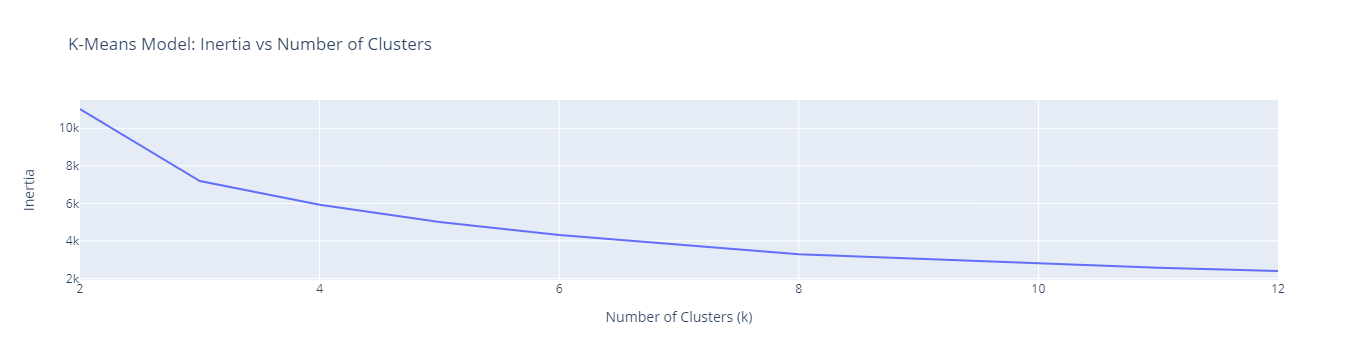

In [70]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
x=n_clusters,y=inertia_errors,title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters (k)",yaxis_title="Inertia")
fig.show()

You can see that the line starts to flatten out around 4 or 5 clusters.

<div class="alert alert-block alert-info">
    <p><b>Note:</b> We ended up using 5 clusters last time, too, but that's because we're working with very similar data. 5 clusters isn't always going to be the right choice for this type of analysis, as we'll see below.</p></div>

Let's make another line plot based on the silhouette scores.

In [71]:
VimeoVideo("714610912", h="01961ee57a", width=600)

**Task 6.3.14:** Use plotly express to create a line plot that shows the values of `silhouette_scores` as a function of `n_clusters`. Be sure to label your x-axis `"Number of Clusters"`, your y-axis `"Silhouette Score"`, and use the title `"K-Means Model: Silhouette Score vs Number of Clusters"`.

- [What's a line plot?](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)
- [Create a line plot in plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

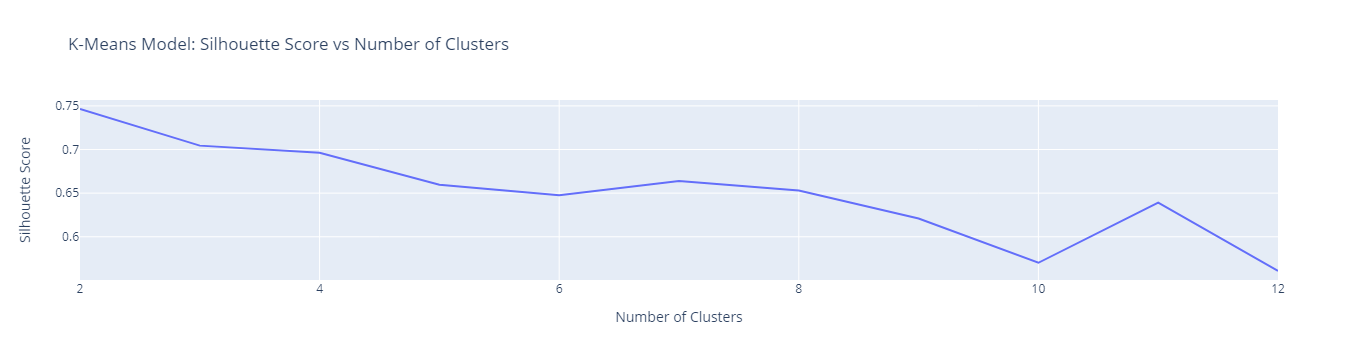

In [73]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters",yaxis_title="Silhouette Score")
fig.show()

This one's a little less straightforward, but we can see that the best silhouette scores occur when there are 3 or 4 clusters. 

Putting the information from this plot together with our inertia plot, it seems like the best setting for `n_clusters` will be 4. 

In [74]:
VimeoVideo("714610883", h="a6a0431b02", width=600)

**Task 6.3.15:** Build and train a new k-means model named `final_model`. Use the information you gained from the two plots above to set an appropriate value for the `n_clusters` argument. Once you've built and trained your model, submit it to the grader for evaluation.

- [Create a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)
- [Fit a model to training data in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)

In [77]:
final_model = make_pipeline(
StandardScaler(),
    KMeans(n_clusters=4,random_state=42)
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

When you're confident in your model, submit it to the grader.

In [78]:

wqet_grader.grade("Project 6 Assessment", "Task 6.3.14", final_model)

# Communicate

It's time to let everyone know how things turned out. Let's start by grabbing the labels.

In [79]:
VimeoVideo("714610862", h="69ff3fb2c8", width=600)

**Task 6.3.16:** Extract the labels that your `final_model` created during training and assign them to the variable `labels`.

- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [80]:
labels = final_model.named_steps["kmeans"].labels_
print(labels[:5])

[0 0 0 0 0]


We're going to make a visualization, so we need to create a new DataFrame to work with.

In [81]:
VimeoVideo("714610842", h="008a463aca", width=600)

**Task 6.3.17:** Create a DataFrame `xgb` that contains the mean values of the features in `X` for each of the clusters in your `final_model`.

- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)
- [Aggregate data using the groupby method in pandas.](../%40textbook/04-pandas-advanced.ipynb#Series-and-Groupby)
- [Create a DataFrame from a Series in pandas.](../%40textbook/04-pandas-advanced.ipynb#Series-and-Groupby)

In [82]:
xgb = X.groupby(labels).mean()
xgb

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,26551.075439,13676.153182,13745.637777,2.722605e+04,4.022723e+04
1,218112.818182,174713.441558,257403.246753,3.305884e+05,3.928263e+05
2,116160.779817,965764.155963,264339.449541,7.800611e+05,1.081925e+06
3,732937.575758,760397.575758,826136.363636,1.276227e+06,1.493335e+06


Now that we have a DataFrame, let's make a bar chart and see how our clusters differ. 

In [83]:
VimeoVideo("714610772", h="e118407ff1", width=600)

**Task 6.3.18:** Use plotly express to create a side-by-side bar chart from `xgb` that shows the mean of the features in `X` for each of the clusters in your `final_model`. Be sure to label the x-axis `"Cluster"`, the y-axis `"Value [$]"`, and use the title `"Mean Household Finances by Cluster"`.

- [What's a bar chart?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [Create a bar chart using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Bar-Chart)

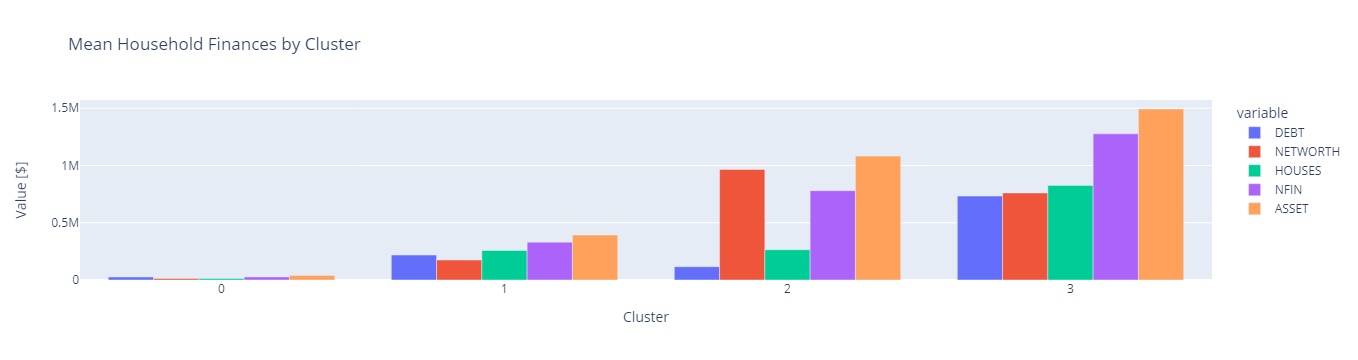

In [85]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
xgb,
 barmode="group",
    title="Mean Household Finances by Cluster"
)
fig.update_layout(xaxis_title="Cluster",yaxis_title="Value [$]")
fig.show()

Remember that our clusters are based partially on `NETWORTH`, which means that the households in the 0 cluster have the smallest net worth, and the households in the 2 cluster have the highest. Based on that, there are some interesting things to unpack here.

First, take a look at the `DEBT` variable. You might think that it would scale as net worth increases, but it doesn't. The lowest amount of debt is carried by the households in cluster 2, even though the value of their houses (shown in green) is roughly the same. You can't *really* tell from this data what's going on, but one possibility might be that the people in cluster 2 have enough money to pay down their debts, but not quite enough money to leverage what they have into additional debts. The people in cluster 3, by contrast, might not need to worry about carrying debt because their net worth is so high. 

Finally, since we started out this project looking at home values, take a look at the relationship between `DEBT` and `HOUSES`. The value of the debt for the people in cluster 0 is higher than the value of their houses, suggesting that most of the debt being carried by those people is tied up in their mortgages — if they own a home at all. Contrast that with the other three clusters: the value of everyone else's debt is lower than the value of their homes.

So all that's pretty interesting, but it's different from what we did last time, right? At this point in the last lesson, we  made a scatter plot. This was a straightforward task because we only worked with two features, so we could plot the data points in two dimensions. But now `X` has five dimensions! How can we plot this to give stakeholders a sense of our clusters?

Since we're working with a computer screen, we don't have much of a choice about the number of dimensions we can use: it's got to be two. So, if we're going to do anything like the scatter plot we made before, we'll need to take our 5-dimensional data and change it into something we can look at in 2 dimensions.

In [86]:
VimeoVideo("714610665", h="19c9f7bf7f", width=600)

**Task 6.3.19:** Create a `PCA` transformer, use it to reduce the dimensionality of the data in `X` to 2, and then put the transformed data into a DataFrame named `X_pca`. The columns of `X_pca` should be named `"PC1"` and `"PC2"`.

- [What's principal component analysis (PCA)?](../%40textbook/16-ml-unsupervised-learning.ipynb#Principal-Component-Analysis)
- [Transform data using a transformer in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [89]:
# Instantiate transformer
pca = PCA(n_components=2,random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t,columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4418, 2)


,PC1,PC2
0,-221525.424530,-22052.273003
1,-217775.100722,-22851.358068
2,-219519.642175,-19023.646333
3,-212195.720367,-22957.107039
4,-215540.507551,-20259.749306


So there we go: our five dimensions have been reduced to two. Let's make a scatter plot and see what we get.

In [90]:
VimeoVideo("714610491", h="755c66fe15", width=600)

**Task 6.3.20:** Use plotly express to create a scatter plot of `X_pca` using seaborn. Be sure to color the data points using the labels generated by your `final_model`. Label the x-axis `"PC1"`, the y-axis `"PC2"`, and use the title `"PCA Representation of Clusters"`.

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a scatter plot using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Scatter-Plots)

In [96]:
labels.astype(str)

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U11')

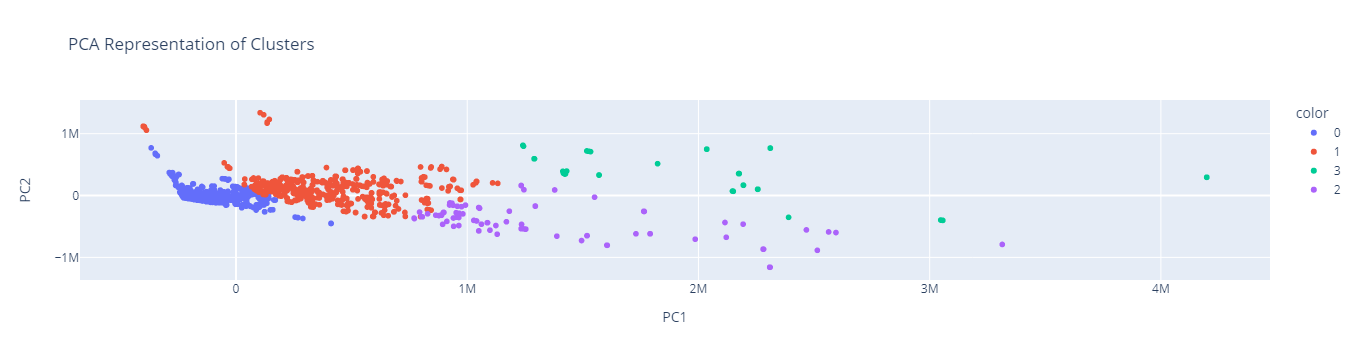

In [95]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")
fig.show()

<div class="alert alert-block alert-info">
<b>Note:</b> You can often improve the performance of PCA by <a href="https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html">standardizing your data first</a>. Give it a try by including a <code>StandardScaler</code> in your transformation of <code>X</code>. How does it change the clusters in your scatter plot? 
</div>

One limitation of this plot is that it's hard to explain what the axes here represent. In fact, both of them are a combination of the five features we originally had in `X`, which means this is pretty abstract. Still, it's the best way we have to show as much information as possible as an explanatory tool for people outside the data science community. 

So what does this graph mean? It means that we made four tightly-grouped clusters that share some key features. If we were presenting this to a group of stakeholders, it might be useful to show this graph first as a kind of warm-up, since most people understand how a two-dimensional object works. Then we could move on to a more nuanced analysis of the data.

Just something to keep in mind as you continue your data science journey.

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
